In [1]:
import tensorflow as tf
import requests
import zipfile
import requests
import os
import time
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import pickle
from tensorflow.keras.models import load_model, Model
from PIL import Image
from PIL.PngImagePlugin import PngImageFile
import matplotlib.pyplot as plt
import glob
from functools import partial
import nltk

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass


def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.13.0


# New Section

In [2]:
import pandas as pd
import requests
import pyarrow.parquet as pq
# '''
# With regard to man-made climate change, the following scores reflect the
# sentiment of the tweet
# 2 is factual
# 1 is pro
# 0 is neutral
# -1 is anti
# Need to manually upload either twitter.zip or twitter_sentiment_data.csv into data folder
# '''
# file_name = "twitter_sentiment_data.csv"
# zip_file_name = "twitter.zip"
# download_path = os.path.join('data', zip_file_name)

# if not os.path.exists('data'):
#         os.mkdir('data')

# if not os.path.exists(os.path.join('data', file_name)):
#   with zipfile.ZipFile(download_path, 'r') as zip_ref:
#     extraction_directory = "data"  # Define your extraction directory
#     os.makedirs(extraction_directory, exist_ok=True)
#     zip_ref.extractall(extraction_directory)
#     print(f"ZIP file contents extracted to '{extraction_directory}'")

# dataframe = pd.read_csv(os.path.join('data','twitter_sentiment_data.csv'))
# print(dataframe.head())
# print(dataframe.keys())

test_file = 'sample_data/test.parquet'
train_file = 'sample_data/train.parquet'

test_table = pq.read_table(test_file)
train_table = pq.read_table(train_file)

train_df = train_table.to_pandas()
test_df = test_table.to_pandas()
dataframe = pd.concat([train_df,test_df])
dataframe.columns = ['message', 'sentiment']
print(dataframe.head())
print(dataframe.keys())

                                             message  sentiment
0  − Scope 3: Optional scope that includes indire...          1
1  The Group is not aware of any noise pollution ...          0
2  Global climate change could exacerbate certain...          0
3  Setting an investment horizon is part and parc...          0
4  Climate change the physical impacts of climate...          0
Index(['message', 'sentiment'], dtype='object')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


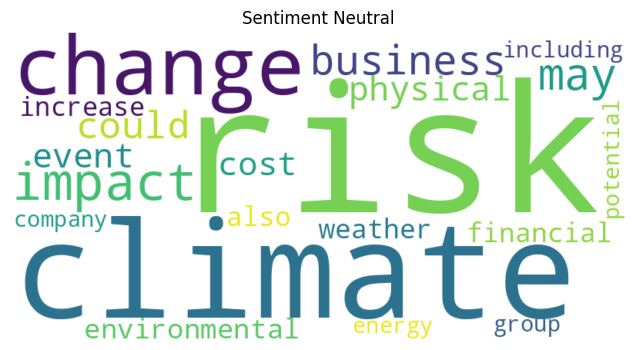

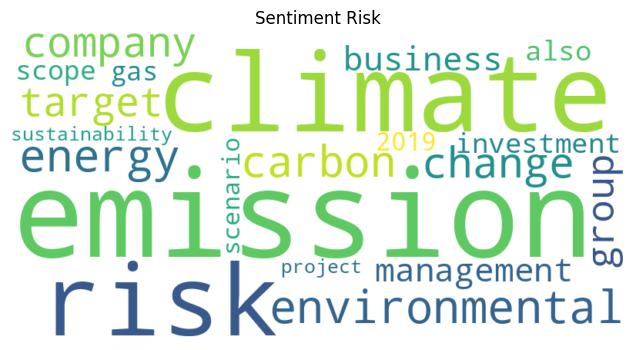

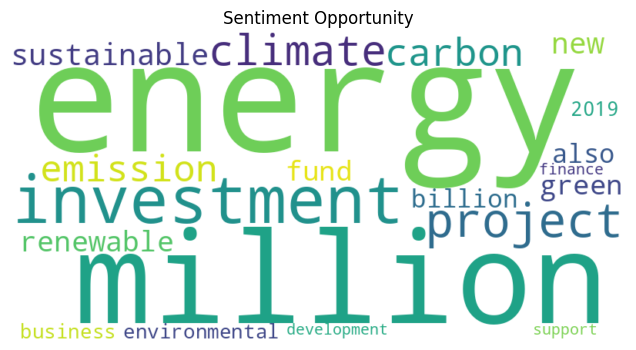

In [36]:
# Word cloud generator
# pip install pandas nltk wordcloud

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df = dataframe

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  # Download WordNet for lemmatization

# Define stopwords
stop_words = set(stopwords.words('english'))

# Initialize WordClouds for each sentiment category
wordclouds = {}

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Filter messages by sentiment category and preprocess
sentiment_label_map = { 0: 'Neutral', 1: 'Risk', 2: 'Opportunity' }
for sentiment_label in [0, 1, 2]:  # Assuming 0 represents neutral, 1 risk, and 2 opportunity
    sentiment_messages = df[df['sentiment'] == sentiment_label]['message']
    sentiment_messages = " ".join(sentiment_messages)

    # Tokenize the text and remove stopwords
    words = nltk.word_tokenize(sentiment_messages)
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum() and word.lower() not in stop_words]

    # Count word frequencies
    word_freq = nltk.FreqDist(words)

    # Get the 20 most common words
    common_words = word_freq.most_common(20)

    # Create a WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_words))

    # Store the WordCloud in the dictionary
    wordclouds[sentiment_label] = wordcloud

# Plot the WordClouds
for sentiment_label, wordcloud in wordclouds.items():
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Sentiment {sentiment_label_map[sentiment_label]}")
    plt.axis("off")
    plt.show()


<ipython-input-41-b1b415b33fa3>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([word[0] for word in common_words], rotation=45, ha="right")


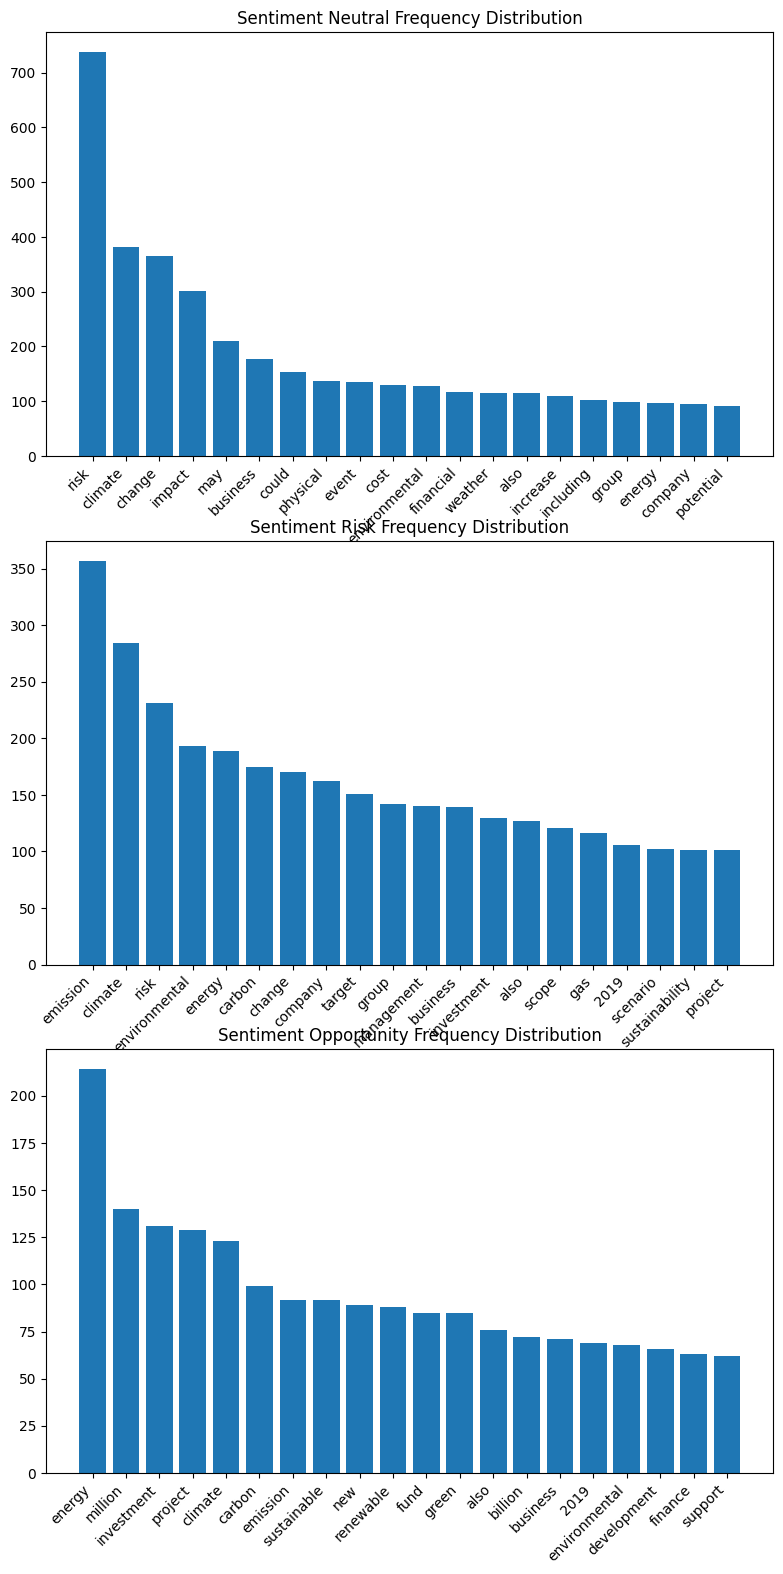

In [41]:
# Frequency graphs

# Initialize frequency distribution plots
fig, axs = plt.subplots(3, 1, figsize=(8, 15))
fig.tight_layout(h_pad=4)  # Increase the vertical spacing between subplots

#  Filter messages by sentiment category and preprocess
sentiment_label_map = {0: 'Neutral', 1: 'Risk', 2: 'Opportunity'}
for i, sentiment_label in enumerate([0, 1, 2]):  # Assuming 0 represents neutral, 1 risk, and 2 opportunity
    sentiment_messages = df[df['sentiment'] == sentiment_label]['message']
    sentiment_messages = " ".join(sentiment_messages)

    # Tokenize the text and remove stopwords
    words = nltk.word_tokenize(sentiment_messages)
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum() and word.lower() not in stop_words]

    # Count word frequencies
    word_freq = nltk.FreqDist(words)

    # Get the 20 most common words
    common_words = word_freq.most_common(20)

    # Plot the frequency distribution graph
    axs[i].bar([word[0] for word in common_words], [word[1] for word in common_words])
    axs[i].set_title(f"Sentiment {sentiment_label_map[sentiment_label]} Frequency Distribution")
    axs[i].set_xticklabels([word[0] for word in common_words], rotation=45, ha="right")

# Show the plots
plt.show()